# SINDy

Discovering governing equations using the SINDy algorithm

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, median_absolute_error

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mape(y_true, y_pred, eps = 1e-8):
    summ = ((np.abs(y_true) + np.abs(y_pred)) + eps)
    return np.mean(np.abs(y_pred - y_true) / summ) * 100

In [34]:


def pendulum(theta, omega, L, g, t_max=10.0, dt=0.01):
    """
    Simulates the motion of a simple pendulum.
    Equation theta'' = -(g/l) * sin(theta)

    Parameters:
        theta (float): Initial angle in radians.
        omega (float): Initial angular velocity in radians per second.
        L (float): Length of the pendulum string.
        g (float): Acceleration due to gravity.
        t_max (float): Maximum simulation tim
        dt (float): timespep

    Returns:
        Tuple: Arrays of time, angle, and angular velocity values.
    """
    # Initialize arrays
    t_values = np.arange(0.0, t_max, dt)
    theta_values = np.zeros_like(t_values)
    omega_values = np.zeros_like(t_values)

    # Set initial conditions
    theta_values[0] = theta
    omega_values[0] = omega

    # Perform simulation
    for i in range(1, len(t_values)):
        # Calculate derivatives
        theta_dot = omega_values[i - 1]
        omega_dot = -(g / L) * np.sin(theta_values[i - 1])

        # Update variables using Euler's method
        theta_values[i] = theta_values[i - 1] + theta_dot * dt
        omega_values[i] = omega_values[i - 1] + omega_dot * dt

    return t_values, theta_values, omega_values



In [35]:
# Define initial conditions and parameters
initial_theta = np.pi / 3  # Initial angle (45 degrees)
initial_omega = 0.0  # Initial angular velocity
pendulum_length = 5  # Length of the pendulum string
gravity = 9.8  # Acceleration due to gravity
dt = 0.01
T = 20
test_size = 0.2
# Simulate the pendulum motion
t, theta, omega = pendulum(initial_theta, initial_omega, pendulum_length, gravity, t_max=T)

In [36]:

def print_scores(y_test, y_pred):
    print(f"R2 score: {r2_score(y_test, y_pred)}")
    print(f"MSE score: {mean_squared_error(y_test, y_pred)}")
    print(f"MAE score: {mean_absolute_error(y_test, y_pred)}")
    print(f"Median AE score: {median_absolute_error(y_test, y_pred)}")
    print(f"MAPE score: {mean_absolute_percentage_error(y_test, y_pred)}")
    print(f"SMAPE score: {symmetric_mape(y_test, y_pred)}")

In [37]:


dum_data = pd.DataFrame({'x': theta})

deg = 4 # Polynomial degree to use

p = PolynomialFeatures(degree=deg, include_bias=True).fit(dum_data)
xpoly = p.fit_transform(dum_data)
newdf = pd.DataFrame(xpoly, columns = p.get_feature_names_out(dum_data.columns))

## add sine and cosine

newdf['sin(x)'] = np.sin(theta)
newdf['cos(x)'] = np.cos(theta)


print("Feature names:", list(newdf))
print("Feature array shape:", newdf.shape)

Feature names: ['1', 'x', 'x^2', 'x^3', 'x^4', 'sin(x)', 'cos(x)']
Feature array shape: (2000, 7)


In [38]:
dt = 0.01
dx1dt = np.gradient(theta, dt)


In [39]:
# Prepare training data
newdf_train, newdf_test, dx1dt_train, dx1dt_test = train_test_split(newdf,
                                                                    dx1dt,
                                                                    shuffle=False,
                                                                    test_size=test_size)

In [40]:
newdf.head()

,1,x,x^2,x^3,x^4,sin(x),cos(x)
0,1.0,1.047198,1.096623,1.148381,1.202581,0.866025,0.500000
1,1.0,1.047198,1.096623,1.148381,1.202581,0.866025,0.500000
2,1.0,1.047028,1.096267,1.147822,1.201802,0.865941,0.500147
3,1.0,1.046688,1.095556,1.146706,1.200244,0.865771,0.500441
4,1.0,1.046179,1.094491,1.145033,1.197910,0.865516,0.500882


In [41]:
mod = Lasso(alpha=0.0001,  max_iter = 10000)
mod

Lasso(alpha=0.0001, max_iter=10000)

In [42]:
# hide
mod.fit(newdf_train, dx1dt_train)
print(mod.coef_)
print(mod.intercept_)
mod.score(newdf_test, dx1dt_test)

[ 0.         -0.          0.2234702   0.13272109 -0.07331071 -0.20587087
 -0.        ]
-0.17620781201672495


-0.23450681502513593

In [43]:
# hide
fit_dx = pd.DataFrame(columns=newdf.columns)
fit_dx.loc[0] = mod.coef_
fit_dx.abs().sort_values(by=0, axis=1, ascending=False)

,x^2,sin(x),x^3,x^4,1,x,cos(x)
0,0.22347,0.205871,0.132721,0.073311,0.0,0.0,0.0


In [44]:
ypred = mod.predict(newdf_test)
print_scores(dx1dt_test, ypred)

R2 score: -0.23450681502513593
MSE score: 1.1888135560702755
MAE score: 0.9422154444454475
Median AE score: 0.9445117538252419
MAPE score: 109.05123127447823
SMAPE score: 93.87310289510054


In [45]:
# Drop features with absolute values less than 0.1
dx_thr = fit_dx[fit_dx.columns[fit_dx.abs().max() > 0.1]]
dx_thr

,x^2,x^3,sin(x)
0,0.22347,0.132721,-0.205871


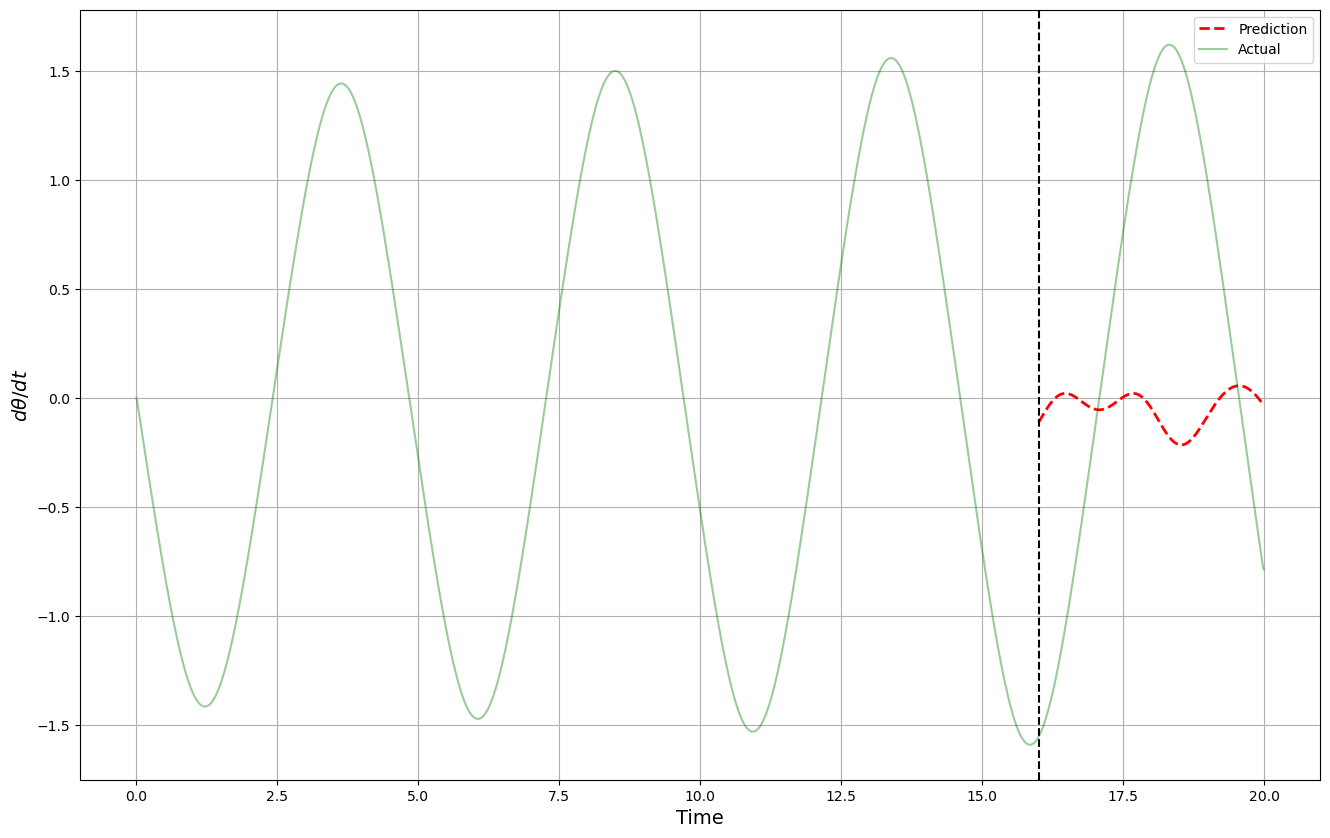

In [46]:

# PLOT results
# time for plots
t = np.arange(0.0, T, dt)
t_test = t[int(len(t)*(1 - test_size)):]

plt.figure(figsize=(16, 10))
plt.plot(t_test, ypred, 'r--', lw = 2, label='Prediction')
plt.plot(t, dx1dt, 'g', label='Actual', alpha=0.4)
plt.axvline(x = (T * (1 - test_size)), color='k', linestyle='--')
plt.xlabel('Time', fontsize=14)
plt.ylabel(r'$d\theta/dt$', fontsize=14)
plt.grid()
plt.legend()
plt.savefig('dthetadt_fit.png', bbox_inches='tight')

In [47]:
#Second order derivative
dxdt2 = np.gradient(dx1dt, dt)[2:-2]
# Prepare training data
newdf_train, newdf_test, dxdt2_train, dxdt2_test = train_test_split(newdf.iloc[2:-2],
                                                                    dxdt2,
                                                                    shuffle=False,
                                                                    test_size=test_size)


In [48]:
mod = Lasso(alpha=0.0001,  max_iter = 10000)
mod

Lasso(alpha=0.0001, max_iter=10000)

In [49]:
# 2 order
mod.fit(newdf_train, dxdt2_train)
print(mod.coef_)
print(mod.intercept_)
mod.score(newdf_test, dxdt2_test)

[ 0.         -1.6206842   0.00200153  0.24855181  0.         -0.33129033
 -0.        ]
-0.0026287303966331804


0.999856993100913

In [50]:
# hide
fit_d2x = pd.DataFrame(columns=newdf.columns)
fit_d2x.loc[0] = mod.coef_
fit_d2x.abs().sort_values(by=0, axis=1, ascending=False)

,x,sin(x),x^3,x^2,1,x^4,cos(x)
0,1.620684,0.33129,0.248552,0.002002,0.0,0.0,0.0


In [51]:
ypred = mod.predict(newdf_test)
print_scores(dxdt2_test, ypred)

R2 score: 0.999856993100913
MSE score: 0.0003089874970034235
MAE score: 0.014067595397625561
Median AE score: 0.01108094752535449
MAPE score: 4.153800648513485
SMAPE score: 1.7157947662462185


In [52]:
# Drop features with absolute values less than 0.1
dx2_thr = fit_d2x[fit_d2x.columns[fit_d2x.abs().max() > 0.1]]
dx2_thr

,x,x^3,sin(x)
0,-1.620684,0.248552,-0.33129


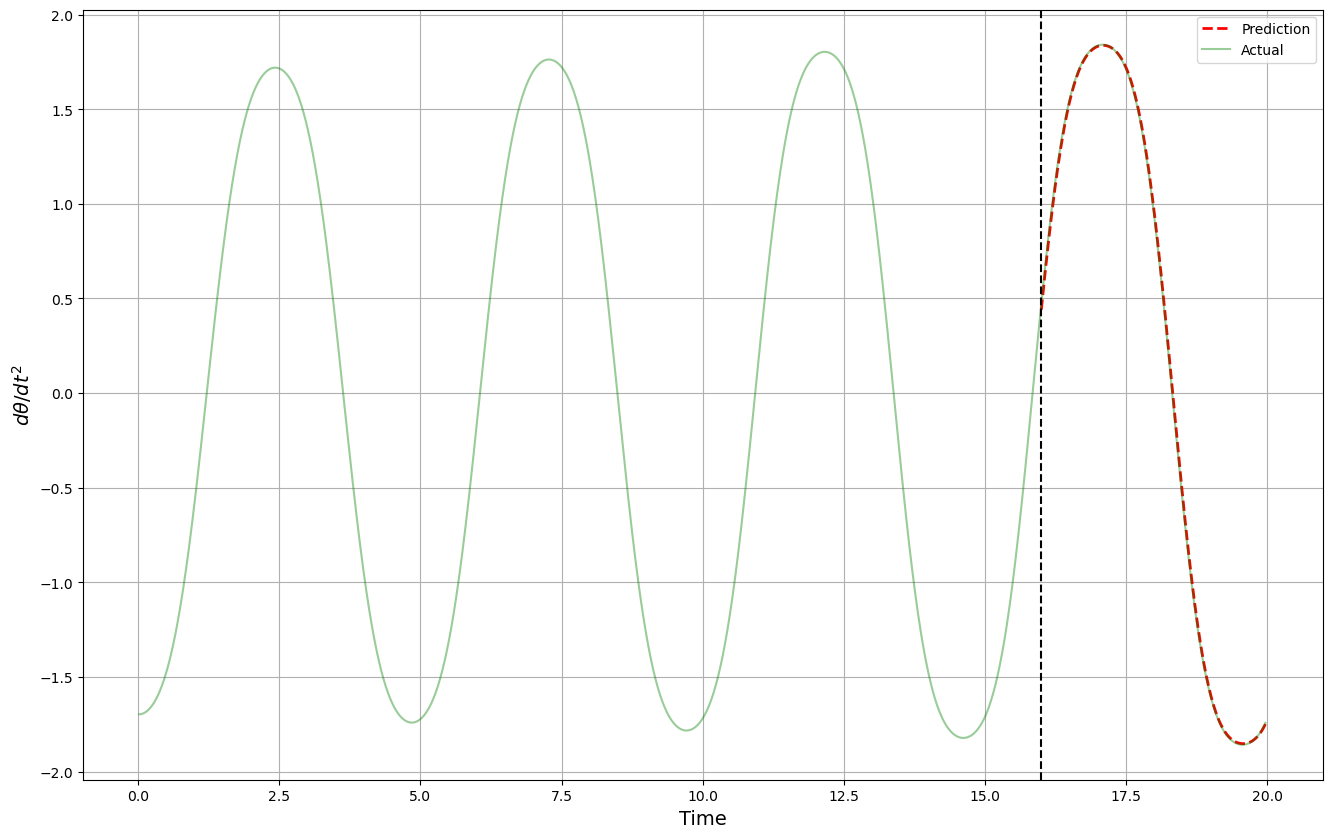

In [53]:

# PLOT results
t = np.arange(0.0, T, dt)
t_test = t[int(len(t)*(1 - test_size)):]


plt.figure(figsize=(16, 10))
plt.plot(t_test, ypred, 'r--', lw = 2, label='Prediction')
plt.plot(t[2:-2], dxdt2, 'g', label='Actual', alpha=0.4)
plt.axvline(x = T * (1 - test_size), color='k', linestyle='--')
plt.xlabel('Time', fontsize=14)
plt.ylabel(r'$d\theta/dt^2$', fontsize=14)
plt.grid()
plt.legend()
plt.savefig('dthetadt2_fit.png', bbox_inches='tight')

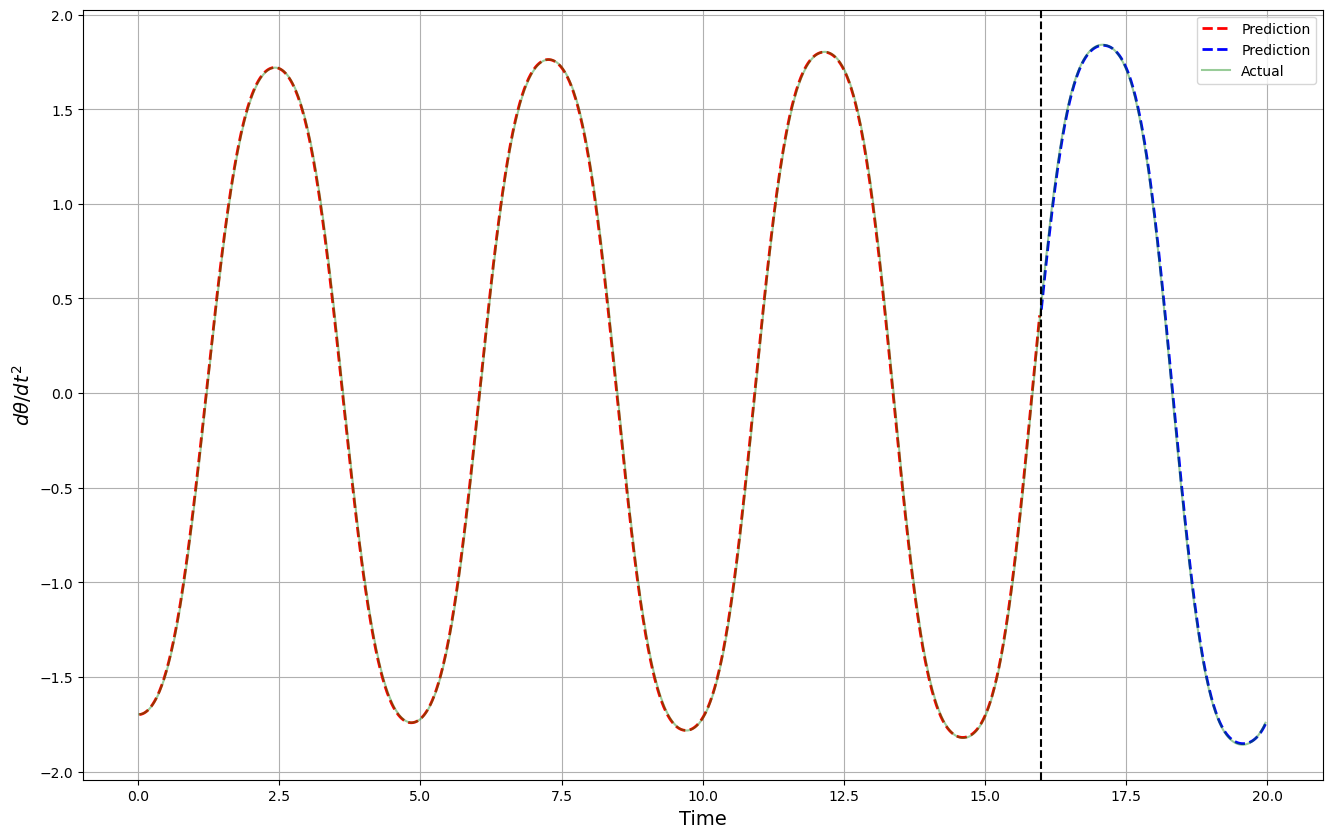

In [54]:

# PLOT results
t = np.arange(0.0, T, dt)
t_test = t[int(len(t)*(1 - test_size)):]

plt.figure(figsize=(16, 10))
plt.plot(t[2:int(len(t)*(1 - test_size))-2], mod.predict(newdf_train), 'r--', lw = 2, label='Prediction')

plt.plot(t_test, ypred, 'b--', lw = 2, label='Prediction')
plt.plot(t[2:-2], dxdt2, 'g', label='Actual', alpha=0.4)
plt.axvline(x = (T * (1 - test_size)), color='k', linestyle='--')
plt.xlabel('Time', fontsize=14)
plt.ylabel(r'$d\theta/dt^2$', fontsize=14)
plt.grid()
plt.legend()